In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa
import pymc3 as pm
import arviz as az

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def pmf_from_dist(dist, qs):
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [3]:
alpha = 1.4
beta = 1
dist1 = ss.gamma(alpha)
dist2 = ss.gamma(alpha, scale=1/beta)

In [4]:
lams = np.linspace(0, 10, 101)
prior1 = pmf_from_dist(dist1, lams)
prior2 = pmf_from_dist(dist2, lams)

In [5]:
prior1 == prior2

0.0     True
0.1     True
0.2     True
0.3     True
0.4     True
        ... 
9.6     True
9.7     True
9.8     True
9.9     True
10.0    True
Name: , Length: 101, dtype: bool

In [6]:
prior_dist = dist1

In [7]:
sample_prior = prior_dist.rvs(1000)
sample_prior_pred = ss.poisson.rvs(sample_prior)

In [8]:
pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

In [9]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

In [10]:
with model:
    trace = pm.sample_prior_predictive(1000)

In [11]:
sample_prior_pymc = trace['lam']
sample_prior_pymc.shape

(1000,)

In [12]:
sample_prior_pred_pymc = trace['goals']
sample_prior_pred_pymc.shape

(1000,)

In [13]:
with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)

In [14]:
options = dict(return_inferencedata=False)
with model2:
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


In [15]:
sample_post_pymc = trace2['lam']

In [16]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

In [17]:
sample_post_pred_pymc = post_pred['goals']

In [18]:
filename = 'WHR20_DataForFigure2.1.xlsx'
df = pd.read_excel(Path.cwd() / 'data' / filename)

In [19]:
score = df['Ladder score']
score.head()

0    7.8087
1    7.6456
2    7.5599
3    7.5045
4    7.4880
Name: Ladder score, dtype: float64

In [20]:
log_gdp = df['Logged GDP per capita']
log_gdp.head()

0    10.639267
1    10.774001
2    10.979933
3    10.772559
4    11.087804
Name: Logged GDP per capita, dtype: float64

In [21]:
result = ss.linregress(log_gdp, score)
result

LinregressResult(slope=0.7177384956304518, intercept=-1.1986460618088826, rvalue=0.7753744007429199, pvalue=5.983050807797873e-32, stderr=0.047570849726545406, intercept_stderr=0.4458597364176077)

In [22]:
x_data = log_gdp
y_data = score

In [23]:
with pm.Model() as model3:
    a = pm.Uniform('a', 0, 4)
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = a * x_data + b
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=y_data)

In [24]:
with model3:
    trace3 = pm.sample(50, **options)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 458 seconds.
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The acceptance probability does not match the target. It is 0.686936625807624, but should be close to 0.8. Try to increase the number of tuning steps.


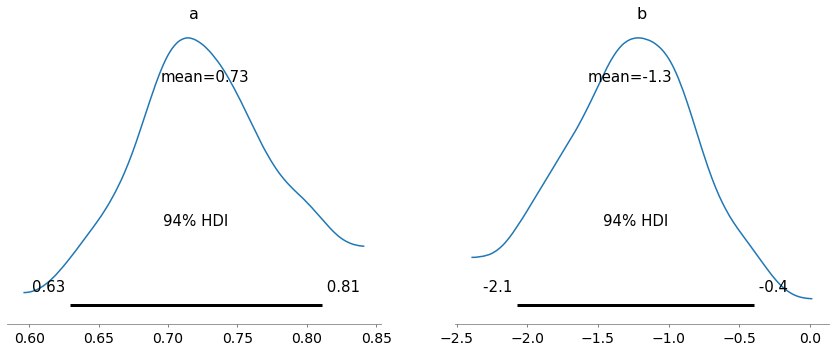

In [26]:
with model3:
    az.plot_posterior(trace3, var_names=['a', 'b'])

In [27]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']
subset = df[columns]

In [28]:
standardized = (subset - subset.mean()) / subset.std()

In [29]:
y_data = standardized['Ladder score']
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

In [30]:
with pm.Model() as model4:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=y_data)

In [31]:
with model4:
    trace4 = pm.sample(25, **options)

Only 25 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, b0]


Sampling 4 chains for 1_000 tune and 25 draw iterations (4_000 + 100 draws total) took 978 seconds.
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [32]:
param_names = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
means = [trace4[name].mean() for name in param_names]

In [33]:
def credible_interval(sample):
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

In [34]:
cis = [credible_interval(trace4[name]) for name in param_names]